ICM(iterated Conditonal Model) 是一种简单的基于MRF的图像恢复或图像分割的模型。

在一种最简单的实现中，我们迭代的对每个像素$p$使得下述代价最小化

$$
C(y_p) = \alpha (1- \delta(y_p, x_p)) + \beta \sum_{q \in N(p)} (1-\delta(y_p, y_q^{(k)}))
$$

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
%load_ext cython

In [2]:
from PIL import Image

In [9]:
jiang = imageio.imread('JZM1962.jpg', pilmode='L')

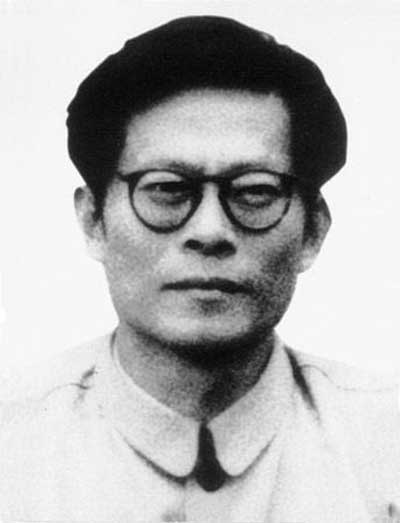

In [10]:
Image.fromarray(jiang)

In [12]:
img = np.zeros_like(jiang)
img[jiang > 128] = 1.

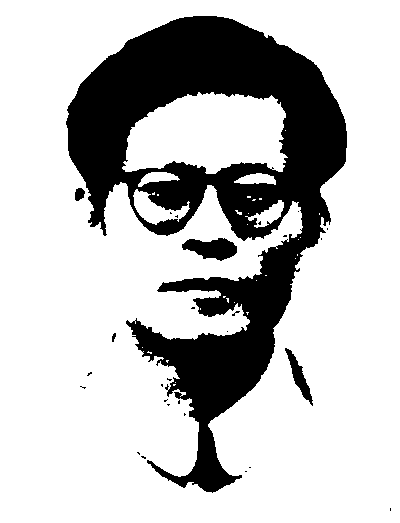

In [15]:
Image.fromarray(img*255)

In [20]:
img_noise = img.copy()
prob_mask = np.random.random(size = img.shape)
p = 0.9
img_noise[prob_mask > p] = 1 - img_noise[prob_mask > p]

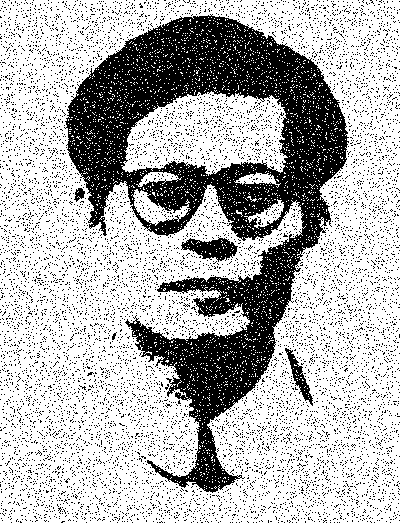

In [21]:
Image.fromarray(img_noise*255)

In [37]:
from IPython.display import display

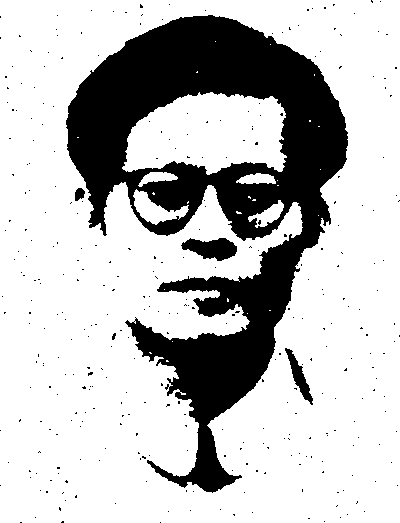

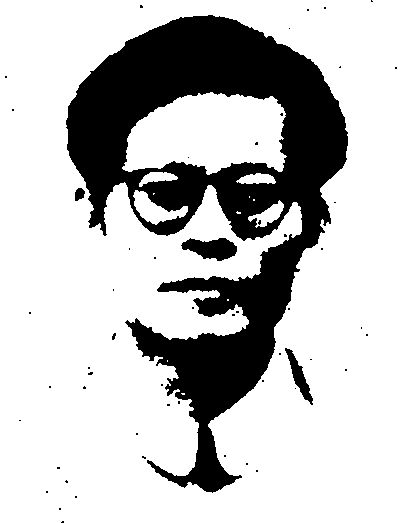

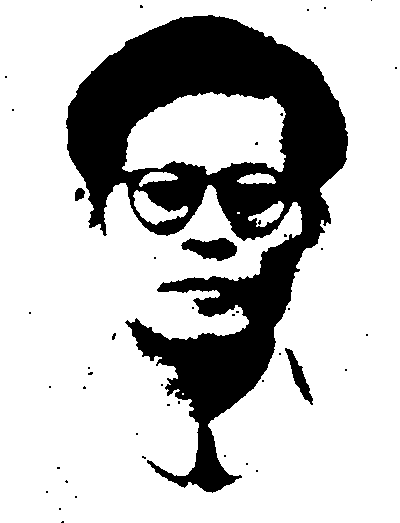

Wall time: 58.5 s


In [96]:
%%time
xs = []
xs.append(img_noise.copy())
alpha = 2.
beta = 1.
m,n = xs[0].shape

for step in range(1,4):
    x = xs[-1]
    y = xs[step-1].copy()
    for i in range(m):
        for j in range(n):
            cost_alpha =  (x[i,j] == [1,0])
            cost_beta = np.zeros(2)
            for di,dj in [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]:
                if i+di>=0 and i+di<m and j+dj>=0 and j+dj<n:
                    cost_beta +=  x[i+di,j+dj] == [1,0]
            cost = alpha * cost_alpha + beta * cost_beta
            y[i,j] = cost[0] > cost[1]
    display(Image.fromarray(y*255))
    xs.append(y)

In [87]:
%%cython --annotate

cimport numpy as np
import numpy as np

def ICM_step_cython(unsigned char [:, :] x, unsigned char[:,:] y, int m, int n, float alpha, float beta):
    cdef int i,j,di,dj
    #cdef float [:] cost_alpha = np.empty(size=2)
    #cdef np.ndarray[np.float_t, ndim=1] cost_alpha = np.zeros(2, dtype=np.int32)
    #cdef np.ndarray[np.float_t, ndim=1] cost_beta = np.zeros(2, dtype=np.int32)
    cdef float cost_alpha0,cost_alpha1,cost_beta0,cost_beta1, cost0, cost1

    for i in range(m):
        for j in range(n):
            #cost_alpha =  (x[i,j] == [1,0])
            #cost_beta = np.zeros(2)
            cost_alpha0 = x[i,j] == 1
            cost_alpha1 = x[i,j] == 0
            cost_beta0 = cost_beta1 = 0.
            #for di,dj in [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]:
            for di in range(-1,2):
                for dj in range(-1,2):
                    if di == 0 and dj == 0:
                        continue
                    if i+di>=0 and i+di<m and j+dj>=0 and j+dj<n:
                        cost_beta0 += x[i+di,j+dj] == 1
                        cost_beta1 += x[i+di,j+dj] == 0
                        #cost_beta[0] = cost_beta[1] = 0.
            cost0 = alpha * cost_alpha0 + beta * cost_beta0
            cost1 = beta * cost_alpha1 + beta*cost_beta1
            y[i,j] = cost0 > cost1

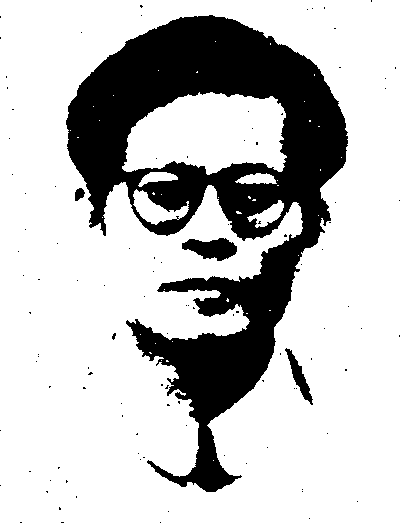

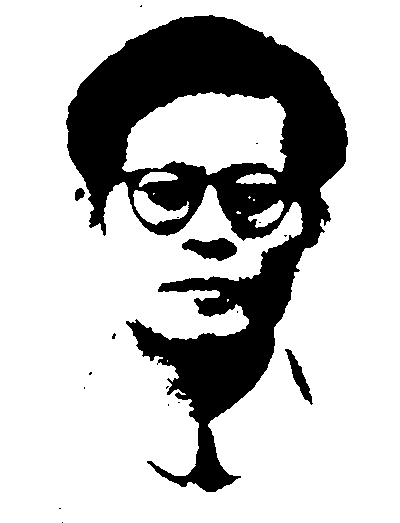

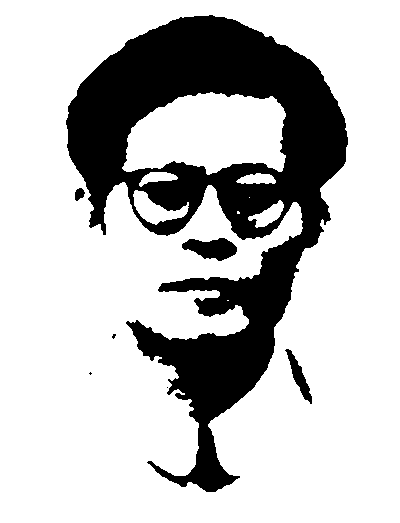

Wall time: 78.4 ms


In [94]:
%%time
x = img_noise.copy()
for i in range(3):
    y = np.zeros_like(x)
    ICM_step_cython(x, y, x.shape[0], x.shape[1], 2.0, 1.0)
    display(Image.fromarray(y*255))
    x = y
    

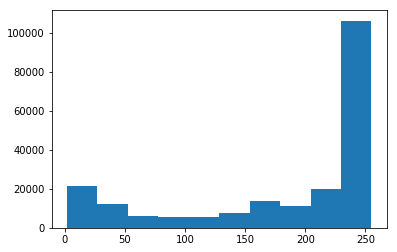

In [98]:
plt.hist(jiang.ravel())
plt.show()

In [99]:
from scipy.optimize import minimize

In [102]:
x = jiang.ravel()
x.shape

(209200,)

$$
p(y_i=y) = p(x_i=0)p(y_i=y \mid x_i = 0) + p(x_i=1)p(y_i=y \mid x_i =1)
$$

$$
\log \prod_i p(Y_i=y) = \sum_i \log (p(X_i=0)p(Y_i=y_i \mid X_i = 0) + p(X_i=1)p(Y_i=y_i \mid X_i =1))
$$

In [108]:
def loglikelihood(params):
    mu1,sd1,mu2,sd2,logp = params
    p = np.exp(logp)
    l1 = 1./(np.sqrt(2*np.pi)*sd1) * np.exp(-((x - mu1)/sd1)**2/2)
    l2 = 1./(np.sqrt(2*np.pi)*sd2) * np.exp(-((x - mu2)/sd2)**2/2)
    l = np.sum(np.log(p * l1 + (1.-p) * l2))
    return l

In [111]:
loglikelihood([0.0,100.0,255.0,100.0,0.0])

-1571298.889455126

In [110]:
loglikelihood([0.0,200.0,255.0,200.0,0.0])

-1404563.7705782673

In [113]:
#minimize(lambda p:-loglikelihood(p), [0.0, 100., 255.0, 100., 0.0])
#这数值问题很大。。还是直方图近似吧，用上面第一个公式即得。

In [121]:
counts, edges = np.histogram(jiang.ravel(), bins=100)
counts.shape,edges.shape

((100,), (101,))

In [134]:
centers = (edges[1:] + edges[:-1])/2.
probs = counts / counts.sum()
probs.sum()

1.0

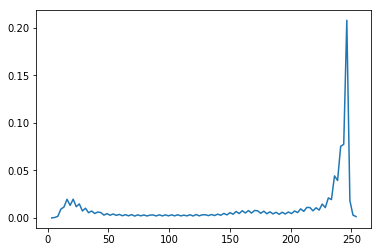

In [135]:
plt.plot(centers, probs)

In [136]:
import scipy.stats as stats

In [144]:
def approx(params):
    mu1,sd1,mu2,sd2,logp = params
    p = np.exp(logp)
    p1 = stats.norm(mu1,sd1).pdf(centers) 
    p1 = p1/ p1.sum()
    p2 = stats.norm(mu2,sd2).pdf(centers)
    p2 = p2/ p2.sum()
    p = p1 * p + p2 * (1-p)
    return p
def func(params):
    p = approx(params)
    return np.sum((p - probs)**2)

In [147]:
res = minimize(func, [50.0,10.,200.,10.,0.0])
res

      fun: 0.040225911007169234
 hess_inv: array([[ 1.10997898e+03, -1.39407544e+04, -5.08899021e+04,
        -1.19524158e+04,  2.05469655e+03],
       [-1.39407544e+04,  1.75247463e+05,  6.39531542e+05,
         1.50266292e+05, -2.58292102e+04],
       [-5.08899021e+04,  6.39531542e+05,  6.23691548e+06,
         2.51820836e+05, -9.45248004e+04],
       [-1.19524158e+04,  1.50266292e+05,  2.51820836e+05,
         1.51379418e+05, -2.21271496e+04],
       [ 2.05469655e+03, -2.58292102e+04, -9.45248004e+04,
        -2.21271496e+04,  3.80981631e+03]])
      jac: array([ 0.00000000e+00,  0.00000000e+00,  6.44940883e-07, -7.32112676e-06,
        0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 385
      nit: 52
     njev: 55
   status: 0
  success: True
        x: array([ 38.68589794, 152.25114552, 671.02399058, 135.5705858 ,
       -21.77347729])

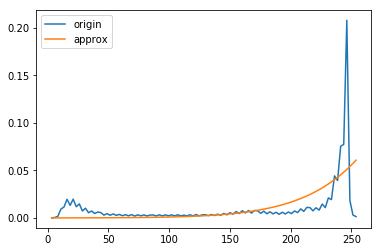

In [148]:
plt.plot(centers, probs, label='origin')
plt.plot(centers, approx(res.x), label='approx')
plt.legend()
plt.show()

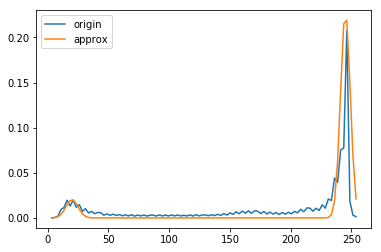

In [173]:
plt.plot(centers, probs, label='origin')
plt.plot(centers, approx([20.,5.,245.,4.,-2.3]), label='approx')
plt.legend()
plt.show()

In [177]:
np.exp(-2.3)

0.10025884372280375

In [176]:
func([20.,5.,245.,4.,-2.3])

0.04978250997279128

In [174]:
res = minimize(func, [20.,5.,245.,4.,-2.3])
res

      fun: 0.008910185507913332
 hess_inv: array([[ 2.80565642e+08,  7.27794375e+09,  8.32230613e+03,
         5.85178513e+03, -2.56236548e+02],
       [ 7.27794375e+09,  1.88791703e+11,  2.15892260e+05,
         1.51873330e+05, -6.66242691e+03],
       [ 8.32230613e+03,  2.15892260e+05,  5.45705458e+01,
         3.18641636e+01, -2.19669565e+00],
       [ 5.85178513e+03,  1.51873330e+05,  3.18641636e+01,
         5.90439785e+01, -8.89433022e+00],
       [-2.56236548e+02, -6.66242691e+03, -2.19669565e+00,
        -8.89433022e+00,  3.04803636e+00]])
      jac: array([-2.63098627e-08, -3.49245965e-10,  8.97108112e-06,  4.03600279e-06,
        7.03765545e-06])
  message: 'Optimization terminated successfully.'
     nfev: 497
      nit: 60
     njev: 71
   status: 0
  success: True
        x: array([ 1.45259820e+02,  3.24733931e+03,  2.45586306e+02,  1.32326048e+00,
       -3.38406018e-01])

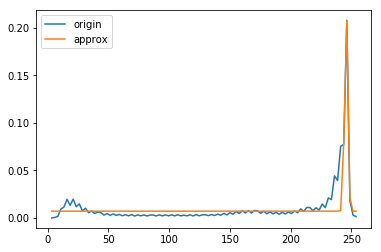

In [175]:
plt.plot(centers, probs, label='origin')
plt.plot(centers, approx(res.x), label='approx')
plt.legend()
plt.show()

In [180]:
mu1, sd1, mu2, sd2, logp = [20.,5.,245.,4.,-2.3]
p = np.exp(logp)
l1 = -((jiang.astype(np.float) - mu1)/sd1)**2/2 + logp
l2 = -((jiang.astype(np.float) - mu2)/sd2)**2/2 +  np.log(1.-np.exp(logp))

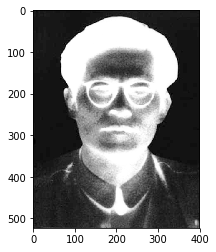

In [185]:
plt.imshow(l1, cmap='gray')

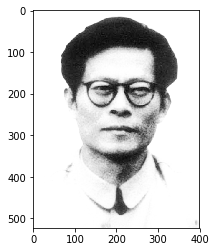

In [186]:
plt.imshow(l2, cmap='gray')

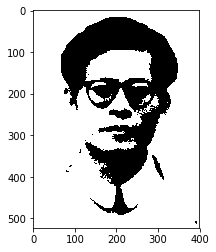

In [188]:
plt.imshow(l1 < l2, cmap='gray')
plt.show()

折腾半天基本就是二值图还行。

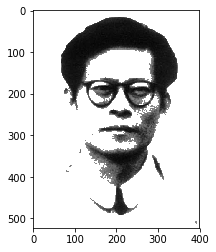

In [197]:
_jiang = jiang.copy()
_jiang[l1 < l2] = 255
plt.imshow(_jiang, cmap='gray')

如原书写的，ICM较一般的MRF的能量函数写法为：

$$
U(x \mid y) = \sum_i \left( \frac{1}{2} \ln \sigma_{x_i}^2 + \frac{(y-\mu_{x_i})^2}{2\sigma_{x_i}^2}+\sum_{n=1}^N \theta_n J(x_i,x_{i+n}) \right)
$$